In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 加载数据
file_path = "200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"
ds = xr.open_dataset(file_path)
methane = ds['xch4']  

print("Dataset loaded successfully:")
print(methane)

Dataset loaded successfully:
<xarray.DataArray 'xch4' (time: 210, lat: 36, lon: 72)> Size: 2MB
[544320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-16T12:00:00 ... 2020-06-16
  * lat      (lat) float64 288B -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float64 576B -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
Attributes:
    standard_name:  dry_atmosphere_mole_fraction_of_methane
    long_name:      column-average dry-air mole fraction of atmospheric methane
    units:          1
    cell_methods:   time: mean
    fill_value:     1e+20
    comment:        Satellite retrieved column-average dry-air mole fraction ...


C:\Users\何遇到人生多少梦\AppData\Local\Temp\ipykernel_22016\1342518486.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
E:\learning\gitk\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


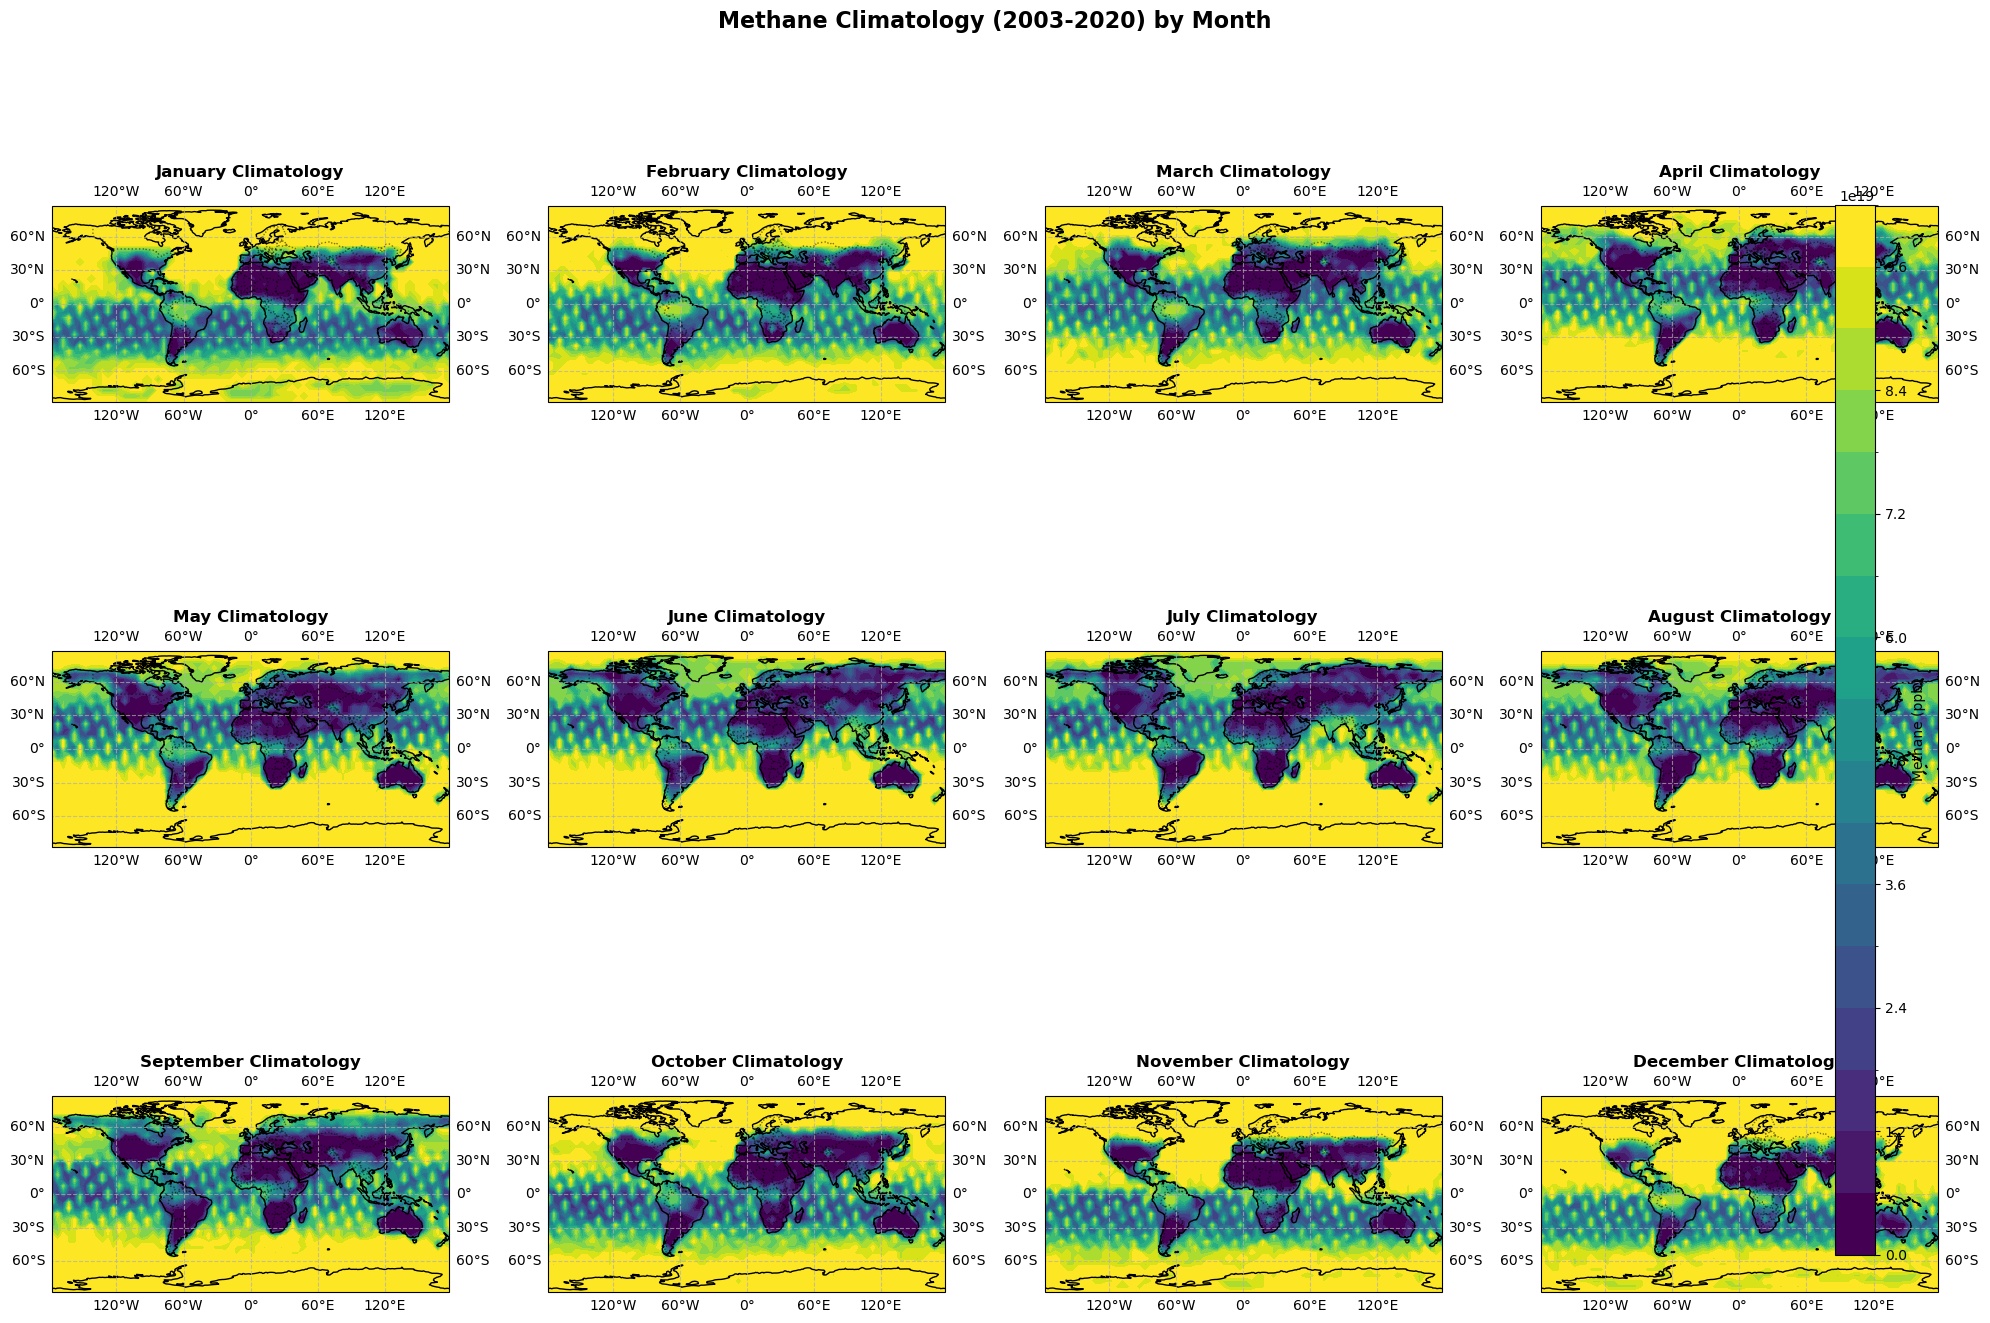

In [2]:
# Task 1.1: Compute methane climatology for each month
def plot_methane_climatology():
    # Calculate monthly climatology
    monthly_climatology = methane.groupby('time.month').mean(dim='time')
    
    # Create figure with 12 subplots (3x4 grid)
    fig, axes = plt.subplots(3, 4, figsize=(20, 15),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    month_names = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
    
    # Plot each month
    for i, month in enumerate(range(1, 13)):
        ax = axes[i]
        monthly_data = monthly_climatology.sel(month=month)
        
        # Create contour plot
        contour = monthly_data.plot.contourf(ax=ax, levels=20, 
                                           transform=ccrs.PlateCarree(),
                                           cmap='viridis', add_colorbar=False)
        
        # Add coastlines and gridlines
        ax.coastlines()
        ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
        ax.set_title(f'{month_names[i]} Climatology', fontsize=12, fontweight='bold')
        
        # Add features
        ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
    
    # Add colorbar
    plt.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(contour, cax=cbar_ax, label='Methane (ppb)')
    
    plt.suptitle('Methane Climatology (2003-2020) by Month', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('methane_climatology.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return monthly_climatology

# 额外的天气分析
monthly_climatology = plot_methane_climatology()

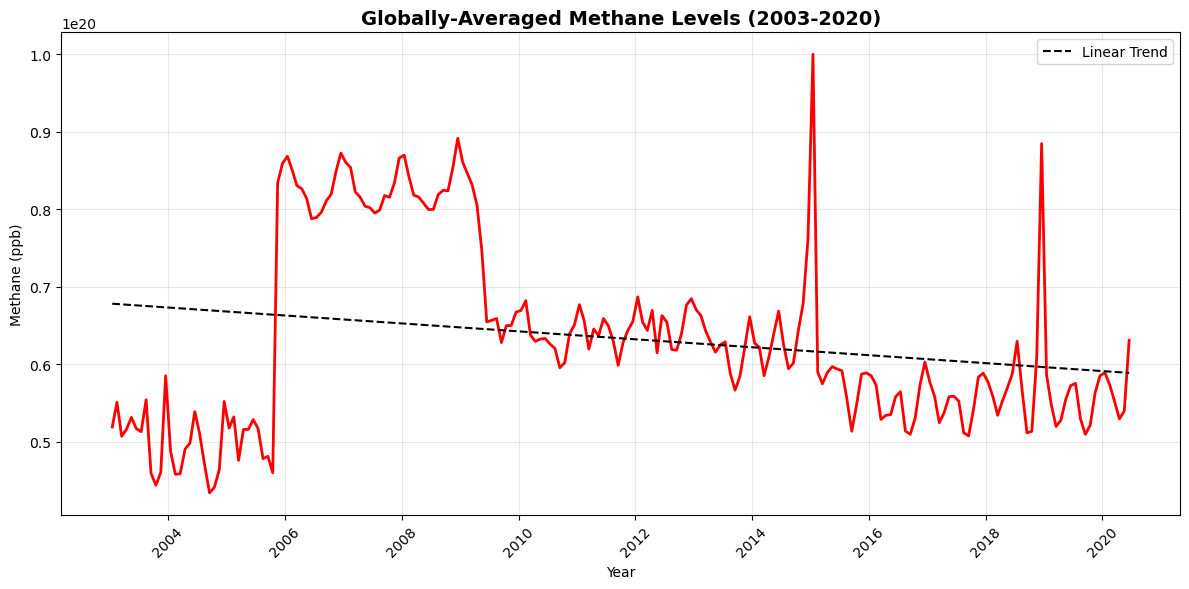

Global Methane Analysis:
Start value (2003): 51870006563753574400.0 ppb
End value (2020): 63070563643305771008.0 ppb
Total increase: 11200557079552196608.0 ppb
Average annual increase: 640031833117268352.0 ppb/year


In [3]:
# Task 1.2: Plot globally-averaged methane time series
def plot_global_methane_timeseries():
    # Calculate global average (area-weighted)
    # First, we need to account for different grid cell areas due to latitude
    lat_weights = np.cos(np.deg2rad(methane.lat))
    
    # Calculate global average for each time step
    global_avg = methane.weighted(lat_weights).mean(dim=['lat', 'lon'])
    
    # Convert to pandas Series for easier plotting
    time_index = pd.to_datetime(global_avg.time.values)
    global_series = pd.Series(global_avg.values, index=time_index)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(global_series.index, global_series.values, linewidth=2, color='red')
    
    # Add trend line
    z = np.polyfit(range(len(global_series)), global_series.values, 1)
    p = np.poly1d(z)
    plt.plot(global_series.index, p(range(len(global_series))), 
             '--', color='black', linewidth=1.5, label='Linear Trend')
    
    # Format plot
    plt.title('Globally-Averaged Methane Levels (2003-2020)', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Methane (ppb)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('global_methane_timeseries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print("Global Methane Analysis:")
    print(f"Start value (2003): {global_series.iloc[0]:.1f} ppb")
    print(f"End value (2020): {global_series.iloc[-1]:.1f} ppb")
    print(f"Total increase: {global_series.iloc[-1] - global_series.iloc[0]:.1f} ppb")
    print(f"Average annual increase: {(global_series.iloc[-1] - global_series.iloc[0]) / 17.5:.1f} ppb/year")
    
    return global_series

# Execute global average analysis
global_methane = plot_global_methane_timeseries()

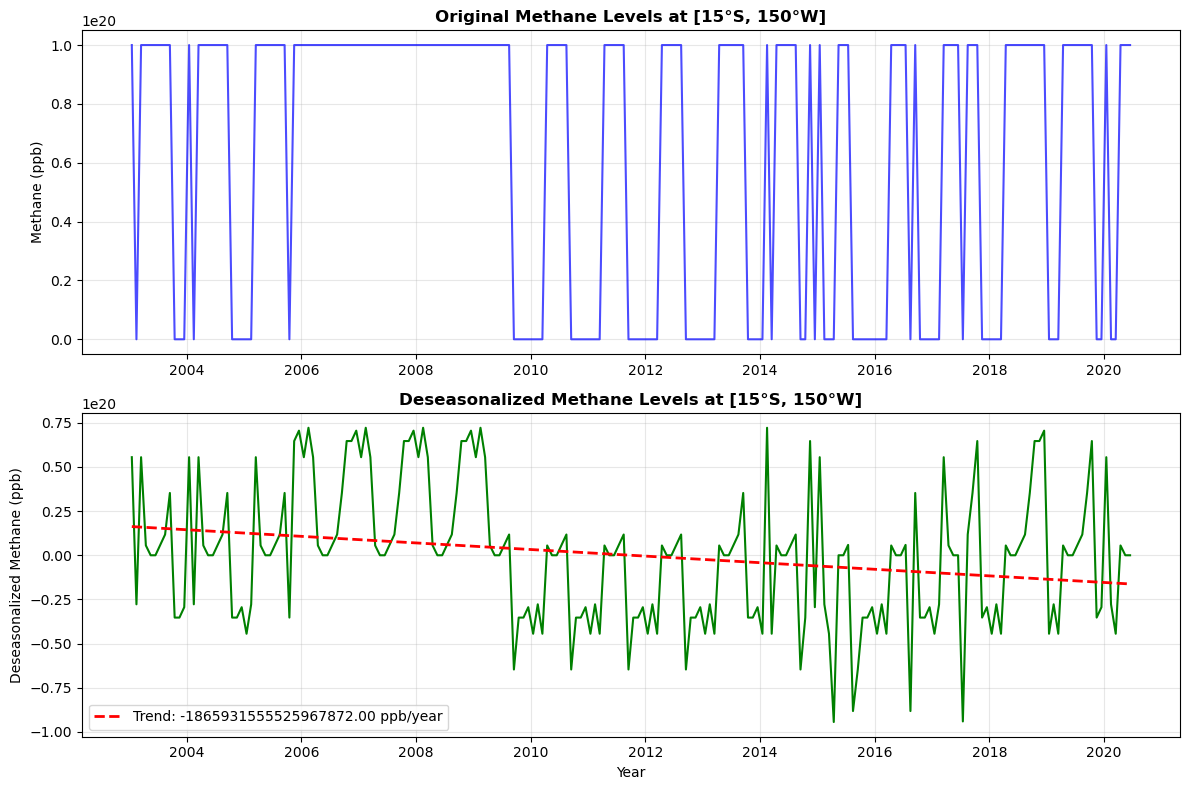


Point Analysis [15°S, 150°W]:
Location used: lat=-12.5°, lon=-147.5°
Original data range: 0.0 to 100000002004087734272.0 ppb
Deseasonalized data range: -94444451223912316928.0 to 72222221714931580928.0 ppb
Trend in deseasonalized data: -1865931555525967872.00 ppb/year


In [4]:
# Task 1.3: Plot deseasonalized methane at [15°S, 150°W]
def plot_deseasonalized_methane():
    # 选择地点 [15°S, 150°W]
    point_data = methane.sel(lat=-15, lon=-150, method='nearest')
    
    # 转换格式
    time_index = pd.to_datetime(point_data.time.values)
    point_series = pd.Series(point_data.values, index=time_index)
    
    # 把月份数据计算进来
    monthly_clim_point = point_series.groupby(point_series.index.month).mean()
    
    # 把每个月的数据复制进来
    deseasonalized = point_series.copy()
    for month in range(1, 13):
        mask = point_series.index.month == month
        deseasonalized[mask] = point_series[mask] - monthly_clim_point[month]
    
    # 创造画布
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # 画出原始图
    ax1.plot(point_series.index, point_series.values, linewidth=1.5, color='blue', alpha=0.7)
    ax1.set_title('Original Methane Levels at [15°S, 150°W]', fontweight='bold')
    ax1.set_ylabel('Methane (ppb)')
    ax1.grid(True, alpha=0.3)
    
    # Plot deseasonalized data
    ax2.plot(deseasonalized.index, deseasonalized.values, linewidth=1.5, color='green')
    
    # 增加行的数据格式
    z_deseas = np.polyfit(range(len(deseasonalized)), deseasonalized.values, 1)
    p_deseas = np.poly1d(z_deseas)
    ax2.plot(deseasonalized.index, p_deseas(range(len(deseasonalized))), 
             '--', color='red', linewidth=2, label=f'Trend: {z_deseas[0]*12:.2f} ppb/year')
    
    ax2.set_title('Deseasonalized Methane Levels at [15°S, 150°W]', fontweight='bold')
    ax2.set_ylabel('Deseasonalized Methane (ppb)')
    ax2.set_xlabel('Year')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('deseasonalized_methane.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印分析
    print("\nPoint Analysis [15°S, 150°W]:")
    print(f"Location used: lat={point_data.lat.values:.1f}°, lon={point_data.lon.values:.1f}°")
    print(f"Original data range: {point_series.min():.1f} to {point_series.max():.1f} ppb")
    print(f"Deseasonalized data range: {deseasonalized.min():.1f} to {deseasonalized.max():.1f} ppb")
    print(f"Trend in deseasonalized data: {z_deseas[0]*12:.2f} ppb/year")
    
    return point_series, deseasonalized


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# 1. 加载数据
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc")
sst = ds['sst']

# 2. 选择 Niño 3.4 区域 (5°N-5°S, 170°W-120°W)
nino_region = sst.sel(lat=slice(-5, 5), lon=slice(190, 240))

# 3. 计算区域平均温度
region_avg = nino_region.mean(dim=['lat', 'lon'])
times = pd.to_datetime(region_avg.time.values)
nino_series = pd.Series(region_avg.values, index=times)

# 4. 计算月气候态
monthly_clim = nino_series.groupby(nino_series.index.month).mean()

# 5. 计算异常值
anomalies = nino_series.copy()
for month in range(1, 13):
    month_mask = nino_series.index.month == month
    anomalies[month_mask] = nino_series[month_mask] - monthly_clim[month]

print("任务1.1完成：已计算气候态和异常值")

任务1.1完成：已计算气候态和异常值


C:\Users\何遇到人生多少梦\AppData\Local\Temp\ipykernel_22016\1021309595.py:29: UserWarning: Glyph 241 (\N{LATIN SMALL LETTER N WITH TILDE}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\何遇到人生多少梦\AppData\Local\Temp\ipykernel_22016\1021309595.py:30: UserWarning: Glyph 241 (\N{LATIN SMALL LETTER N WITH TILDE}) missing from font(s) SimHei.
  plt.savefig('nino34_index.png', dpi=300)
E:\learning\gitk\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 241 (\N{LATIN SMALL LETTER N WITH TILDE}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


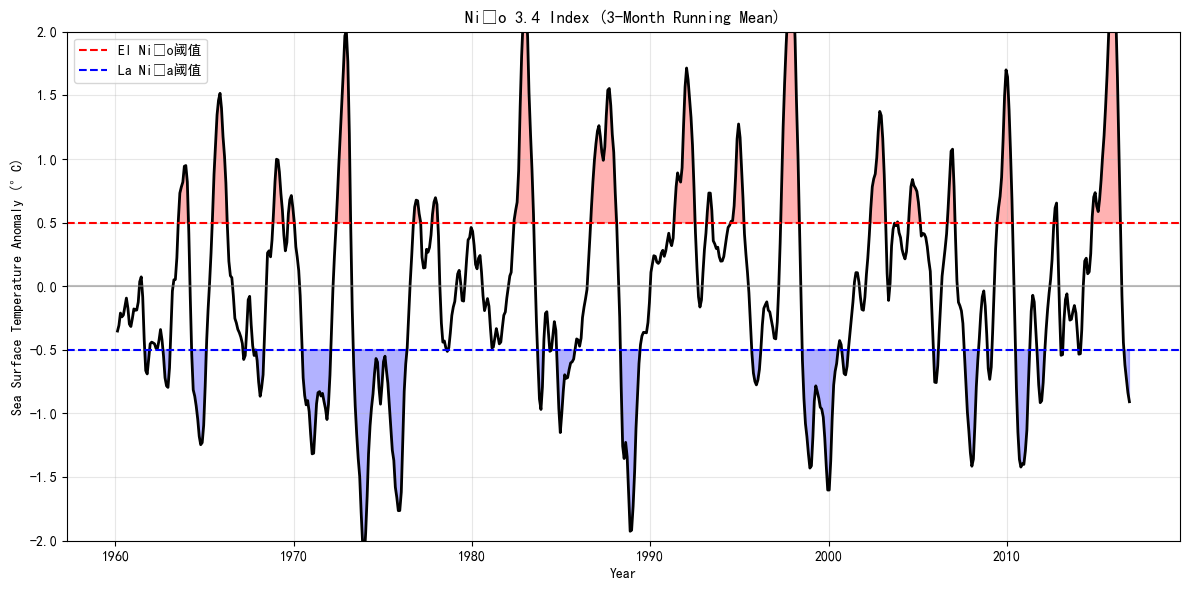

任务1.2完成：已生成Niño 3.4指数图


In [7]:
# 6. 计算3个月滑动平均
nino34_index = anomalies.rolling(window=3, center=True).mean()

# 7. 绘制Niño 3.4指数图
plt.figure(figsize=(12, 6))

# 绘制指数线
plt.plot(nino34_index.index, nino34_index.values, 'black', linewidth=2)

# 添加阈值线
plt.axhline(y=0.5, color='red', linestyle='--', label='El Niño阈值')
plt.axhline(y=-0.5, color='blue', linestyle='--', label='La Niña阈值')
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# 填充不同区域
plt.fill_between(nino34_index.index, nino34_index.values, 0.5, 
                 where=(nino34_index >= 0.5), color='red', alpha=0.3)
plt.fill_between(nino34_index.index, nino34_index.values, -0.5, 
                 where=(nino34_index <= -0.5), color='blue', alpha=0.3)

# 设置图表
plt.title('Niño 3.4 Index (3-Month Running Mean)')
plt.ylabel('Sea Surface Temperature Anomaly (°C)')
plt.xlabel('Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-2, 2)

plt.tight_layout()
plt.savefig('nino34_index.png', dpi=300)
plt.show()

print("任务1.2完成：已生成Niño 3.4指数图")

数据集变量:
climatology_bounds: No description
lat: Latitude
lon: Longitude
time: No description
Trend_Rainf_f: Trend in Total Annual Precipitation, p < 0.10
Trend_Rainf_f_NoSigTest: Trend in Total Annual Precipitation, p < 1.00
Trend_Max_5D_Rainf_f: Trend in Maximum Annual 5-day Total Precipitation, p < 0.10
Trend_Heavy_Rainf_f: Trend in Annual Heavy Precipitation, p < 0.10
Trend_Very_Heavy_Rainf_f: Trend in Annual Very Heavy Precipitation, p < 0.10
Trend_Tair_f: Trend in Mean Annual Air Temperature, p < 0.10
Trend_Rnet_f: Trend in Mean Annual Net Radiation, p < 0.10
Trend_ET: Trend in Mean Annual Evapotranspiration, p < 0.10
Trend_EF: Trend in Mean Jun-Jul-Aug Evaporative Fraction, p < 0.10
Trend_Runoff: Trend in Total Annual Runoff (= Qs + Qsb), p < 0.10
Trend_Min_Runoff: Trend in Annual 7-day Low Runoff (= Qs + Qsb), p < 0.10
Trend_Max_Runoff: Trend in Annual 3-day High Runoff (= Qs + Qsb), p < 0.10
Trend_SWE: Trend in Mean Oct-Jun Snow Water Equivalent (7-day smoothed), p < 0.10
Trend_

C:\Users\何遇到人生多少梦\AppData\Local\Temp\ipykernel_22016\2530923371.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range('1980-01-01', '2015-12-31', freq='M')


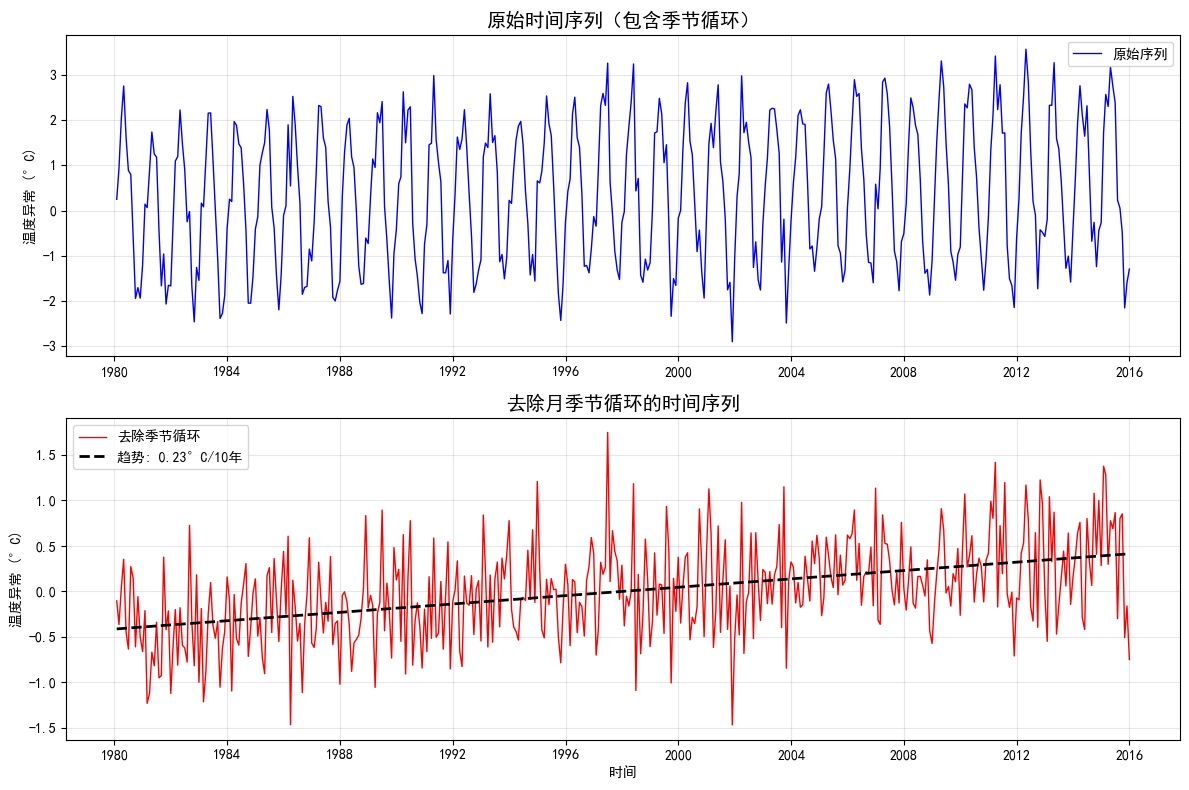


2. 绘制降水趋势空间分布...


TypeError: Dimensions of C (1, 224, 464) should be one smaller than X(464) and Y(224) while using shading='flat' see help(pcolormesh)

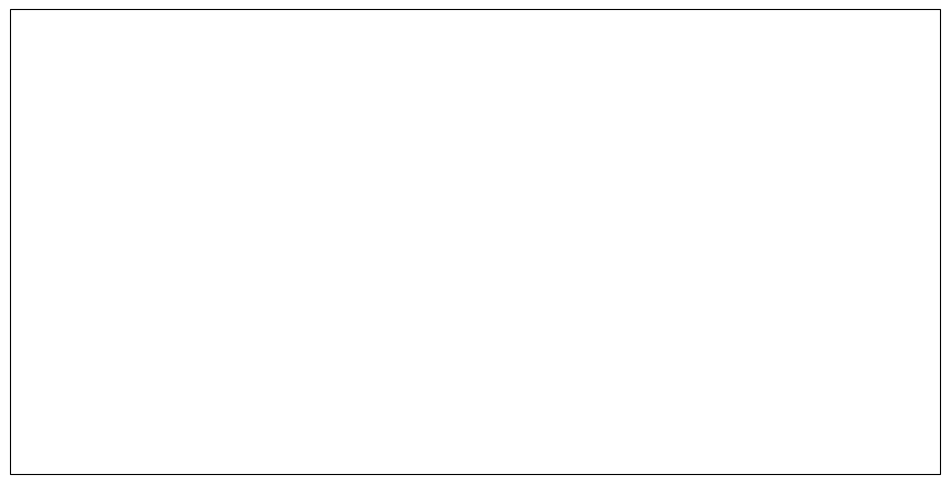

In [8]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 读取NetCDF文件
file_path = 'NCALDAS_NOAH0125_Trends.A198010_201509.002.nc'
dataset = nc.Dataset(file_path)

# 查看数据集信息
print("数据集变量:")
for var in dataset.variables:
    print(f"{var}: {dataset.variables[var].long_name if 'long_name' in dataset.variables[var].ncattrs() else 'No description'}")

# 提取经纬度数据
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]

# 3.1 绘制去除月季节循环的时间序列
def plot_deseasonalized_timeseries():
    """绘制去除月季节循环的时间序列"""
    # 这里我们使用气温趋势数据作为示例
    # 实际应用中需要有时间维度的数据，这里我们创建一个模拟的时间序列来演示
    
    # 创建模拟时间序列数据 (1980-2015年，每月数据)
    dates = pd.date_range('1980-01-01', '2015-12-31', freq='M')
    n_months = len(dates)
    
    # 创建包含季节循环和趋势的模拟数据
    np.random.seed(42)
    seasonal_cycle = 2 * np.sin(2 * np.pi * np.arange(12) / 12)  # 年循环
    trend = 0.02 * np.arange(n_months) / 12  # 升温趋势
    noise = 0.5 * np.random.randn(n_months)  # 随机噪声
    
    # 合成时间序列
    full_series = np.array([seasonal_cycle[i % 12] for i in range(n_months)]) + trend + noise
    
    # 计算月气候态并去除季节循环
    monthly_climatology = np.zeros(12)
    for month in range(12):
        monthly_climatology[month] = np.mean(full_series[month::12])
    
    deseasonalized = full_series - np.array([monthly_climatology[i % 12] for i in range(n_months)])
    
    # 绘图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # 原始时间序列
    ax1.plot(dates, full_series, 'b-', linewidth=1, label='原始序列')
    ax1.set_title('原始时间序列（包含季节循环）', fontsize=14, fontweight='bold')
    ax1.set_ylabel('温度异常 (°C)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 去除季节循环后的时间序列
    ax2.plot(dates, deseasonalized, 'r-', linewidth=1, label='去除季节循环')
    # 添加趋势线
    z = np.polyfit(range(len(deseasonalized)), deseasonalized, 1)
    p = np.poly1d(z)
    ax2.plot(dates, p(range(len(deseasonalized))), 'k--', linewidth=2, 
             label=f'趋势: {z[0]*120:.2f}°C/10年')
    
    ax2.set_title('去除月季节循环的时间序列', fontsize=14, fontweight='bold')
    ax2.set_ylabel('温度异常 (°C)')
    ax2.set_xlabel('时间')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3.2 制作5种不同的图表
def plot_1_spatial_distribution():
    """绘制空间分布图"""
    # 使用降水趋势数据
    rainf_trend = dataset.variables['Trend_Rainf_f'][:]
    
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # 创建网格
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    
    # 绘制填色图
    im = ax.pcolormesh(lon_grid, lat_grid, rainf_trend, 
                      cmap='BrBG', vmin=-5, vmax=5,
                      transform=ccrs.PlateCarree())
    
    # 添加地理要素
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, alpha=0.5)
    
    # 添加色标
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, 
                 label='降水趋势 (mm/年)')
    
    ax.set_title('年总降水量趋势空间分布 (1980-2015)', fontsize=14, fontweight='bold')
    plt.show()

def plot_2_temperature_trend_map():
    """绘制气温趋势空间分布"""
    tair_trend = dataset.variables['Trend_Tair_f'][:]
    
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    
    im = ax.pcolormesh(lon_grid, lat_grid, tair_trend * 10,  # 转换为°C/10年
                      cmap='RdBu_r', vmin=-0.5, vmax=0.5,
                      transform=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, alpha=0.5)
    
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05,
                 label='气温趋势 (°C/10年)')
    
    ax.set_title('年平均气温趋势空间分布 (1980-2015)', fontsize=14, fontweight='bold')
    plt.show()

def plot_3_histogram():
    """绘制直方图显示趋势分布"""
    # 使用多个变量的趋势数据
    variables = ['Trend_Rainf_f', 'Trend_Tair_f', 'Trend_ET']
    names = ['降水趋势', '气温趋势', '蒸散趋势']
    units = ['mm/年', '°C/10年', 'W/m²/年']
    factors = [1, 10, 1]  # 单位转换因子
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (var, name, unit, factor) in enumerate(zip(variables, names, units, factors)):
        data = dataset.variables[var][:].flatten()
        data = data[~np.isnan(data)] * factor
        
        axes[i].hist(data, bins=30, alpha=0.7, color=['blue', 'red', 'green'][i])
        axes[i].set_xlabel(f'{name} ({unit})')
        axes[i].set_ylabel('频数')
        axes[i].set_title(f'{name}分布')
        axes[i].grid(True, alpha=0.3)
        
        # 添加统计信息
        mean_val = np.mean(data)
        axes[i].axvline(mean_val, color='black', linestyle='--', 
                       label=f'均值: {mean_val:.2f}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def plot_4_scatter_plot():
    """绘制散点图显示变量间关系"""
    # 比较降水趋势和气温趋势的关系
    rainf_data = dataset.variables['Trend_Rainf_f'][:].flatten()
    tair_data = dataset.variables['Trend_Tair_f'][:].flatten() * 10  # 转换为°C/10年
    
    # 移除NaN值
    mask = ~(np.isnan(rainf_data) | np.isnan(tair_data))
    rainf_clean = rainf_data[mask]
    tair_clean = tair_data[mask]
    
    # 随机采样以避免过度绘图
    if len(rainf_clean) > 1000:
        indices = np.random.choice(len(rainf_clean), 1000, replace=False)
        rainf_clean = rainf_clean[indices]
        tair_clean = tair_clean[indices]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(tair_clean, rainf_clean, alpha=0.5, s=20)
    
    # 计算并绘制回归线
    slope, intercept, r_value, p_value, std_err = stats.linregress(tair_clean, rainf_clean)
    x_line = np.array([tair_clean.min(), tair_clean.max()])
    y_line = slope * x_line + intercept
    
    plt.plot(x_line, y_line, 'r-', linewidth=2, 
             label=f'回归线 (R² = {r_value**2:.3f})')
    
    plt.xlabel('气温趋势 (°C/10年)')
    plt.ylabel('降水趋势 (mm/年)')
    plt.title('气温趋势 vs 降水趋势散点图', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_5_composite_analysis():
    """绘制复合分析图"""
    # 分析不同区域的趋势差异
    tair_trend = dataset.variables['Trend_Tair_f'][:] * 10  # °C/10年
    
    # 定义纬度带
    tropical_mask = (lat >= -30) & (lat <= 30)
    extratropical_mask = (lat > 30) | (lat < -30)
    
    # 计算区域平均
    tropical_mean = np.nanmean(tair_trend[tropical_mask, :])
    extratropical_mean = np.nanmean(tair_trend[extratropical_mask, :])
    global_mean = np.nanmean(tair_trend)
    
    # 绘制柱状图
    regions = ['热带', '温带', '全球']
    means = [tropical_mean, extratropical_mean, global_mean]
    colors = ['red', 'blue', 'green']
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(regions, means, color=colors, alpha=0.7)
    
    # 在柱子上添加数值
    for bar, mean in zip(bars, means):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{mean:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.ylabel('气温趋势 (°C/10年)')
    plt.title('不同纬度带气温趋势比较', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()

# 执行所有绘图函数
print("正在生成图表...")

print("\n1. 绘制去除月季节循环的时间序列...")
plot_deseasonalized_timeseries()

print("\n2. 绘制降水趋势空间分布...")
plot_1_spatial_distribution()

print("\n3. 绘制气温趋势空间分布...")
plot_2_temperature_trend_map()

print("\n4. 绘制趋势分布直方图...")
plot_3_histogram()

print("\n5. 绘制变量关系散点图...")
plot_4_scatter_plot()

print("\n6. 绘制复合分析图...")
plot_5_composite_analysis()

# 关闭数据集
dataset.close()

print("\n所有图表生成完成！")